In [ ]:
!pip install pgmpy networkx matplotlib

In [ ]:
!pip install --upgrade pgmpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BIC
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AirQualityUCI.xlsx to AirQualityUCI.xlsx


In [ ]:
file_path = 'AirQualityUCI.xlsx'
data = pd.ExcelFile(file_path)

In [ ]:
df = data.parse('AirQualityUCI')

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [ ]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550,0.513866
9356,2005-04-04,14:00:00,2.2,1070.75,-200,11.932060,1047.25,265.2,654.00,167.7,1128.50,816.00,28.500,13.125,0.502804


## Unncessary columns

In [ ]:
df_air = df.drop(['Date', 'Time'], axis=1)

## Missing Values

In [ ]:
#Handling missing values and converting to numeric
df_air = df_air.apply(pd.to_numeric, errors='coerce')
df_air.replace(-200, np.nan, inplace=True)
df_air.fillna(df_air.mean(), inplace=True)
df_air.dropna(axis=1, how='any', inplace=True)

In [ ]:
df_air.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


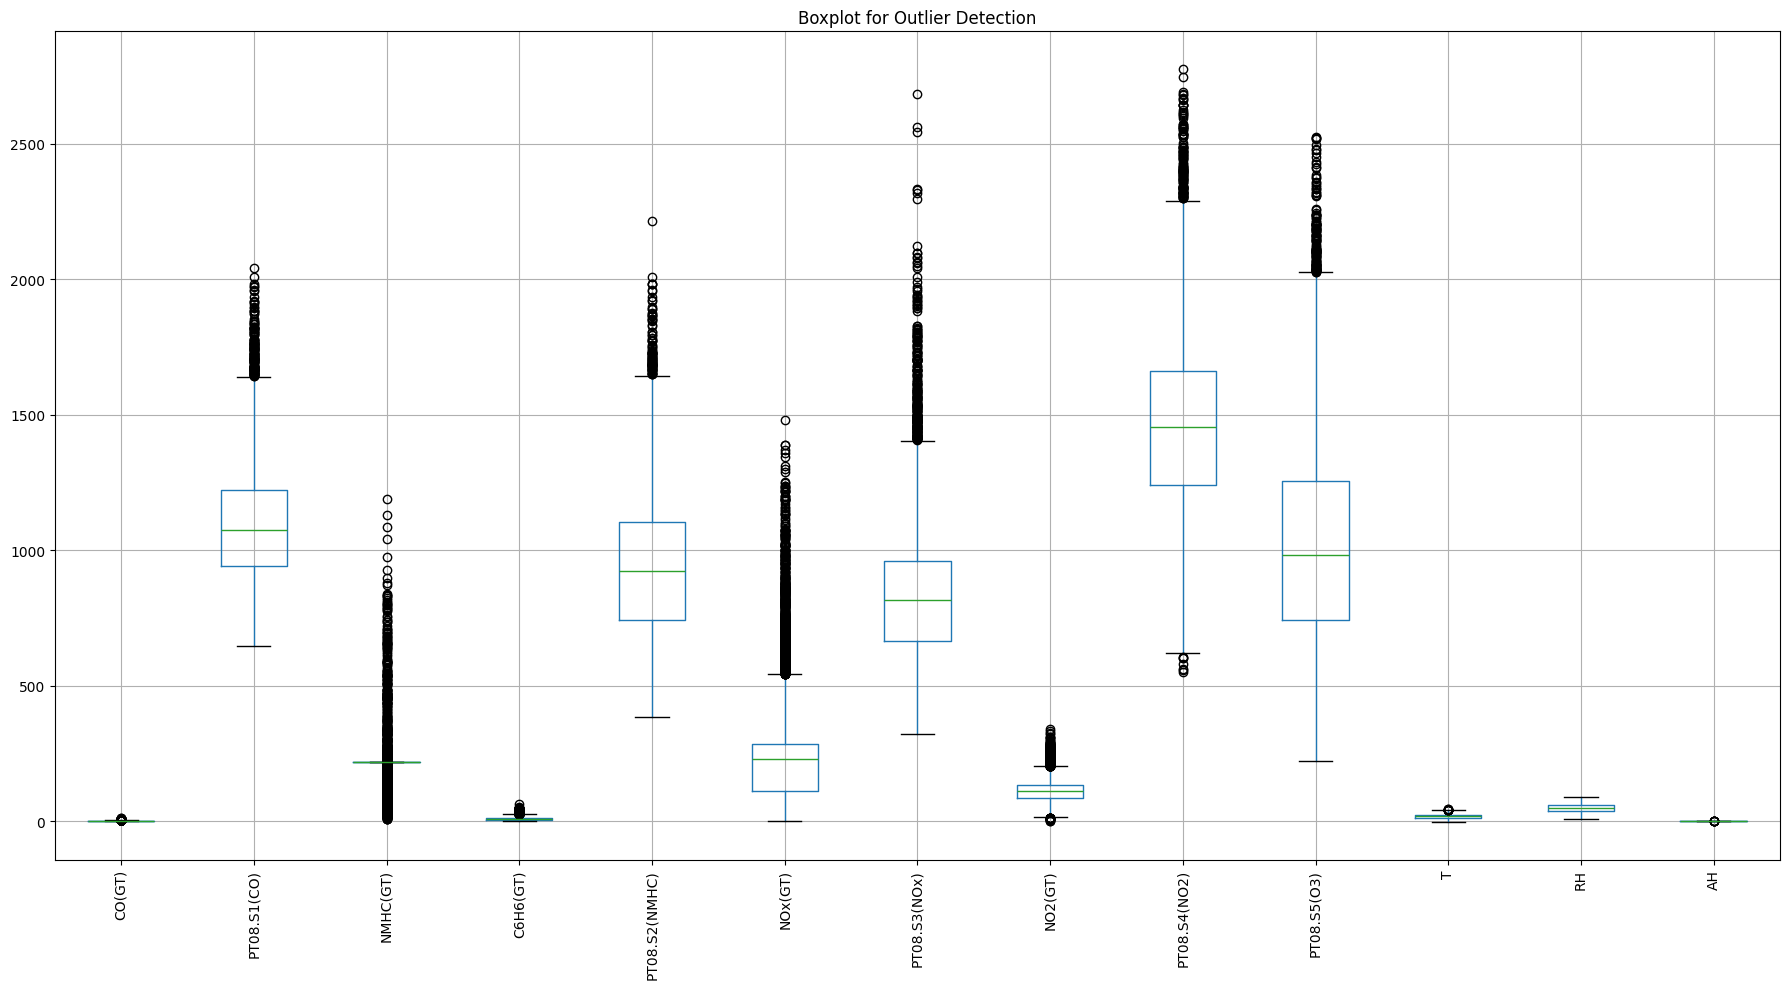

In [ ]:
# outliers
plt.figure(figsize=(18, 10))
df_air.boxplot(rot=90, fontsize=10)
plt.title('Boxplot for Outlier Detection')
plt.tight_layout()
plt.show()

## Handling Outliers

In [ ]:
# Remove outliers using IQR
Q1 = df_air.quantile(0.25)
Q3 = df_air.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
df_air = df_air[~((df_air < lower_bound) | (df_air > upper_bound)).any(axis=1)]

## Heatmap

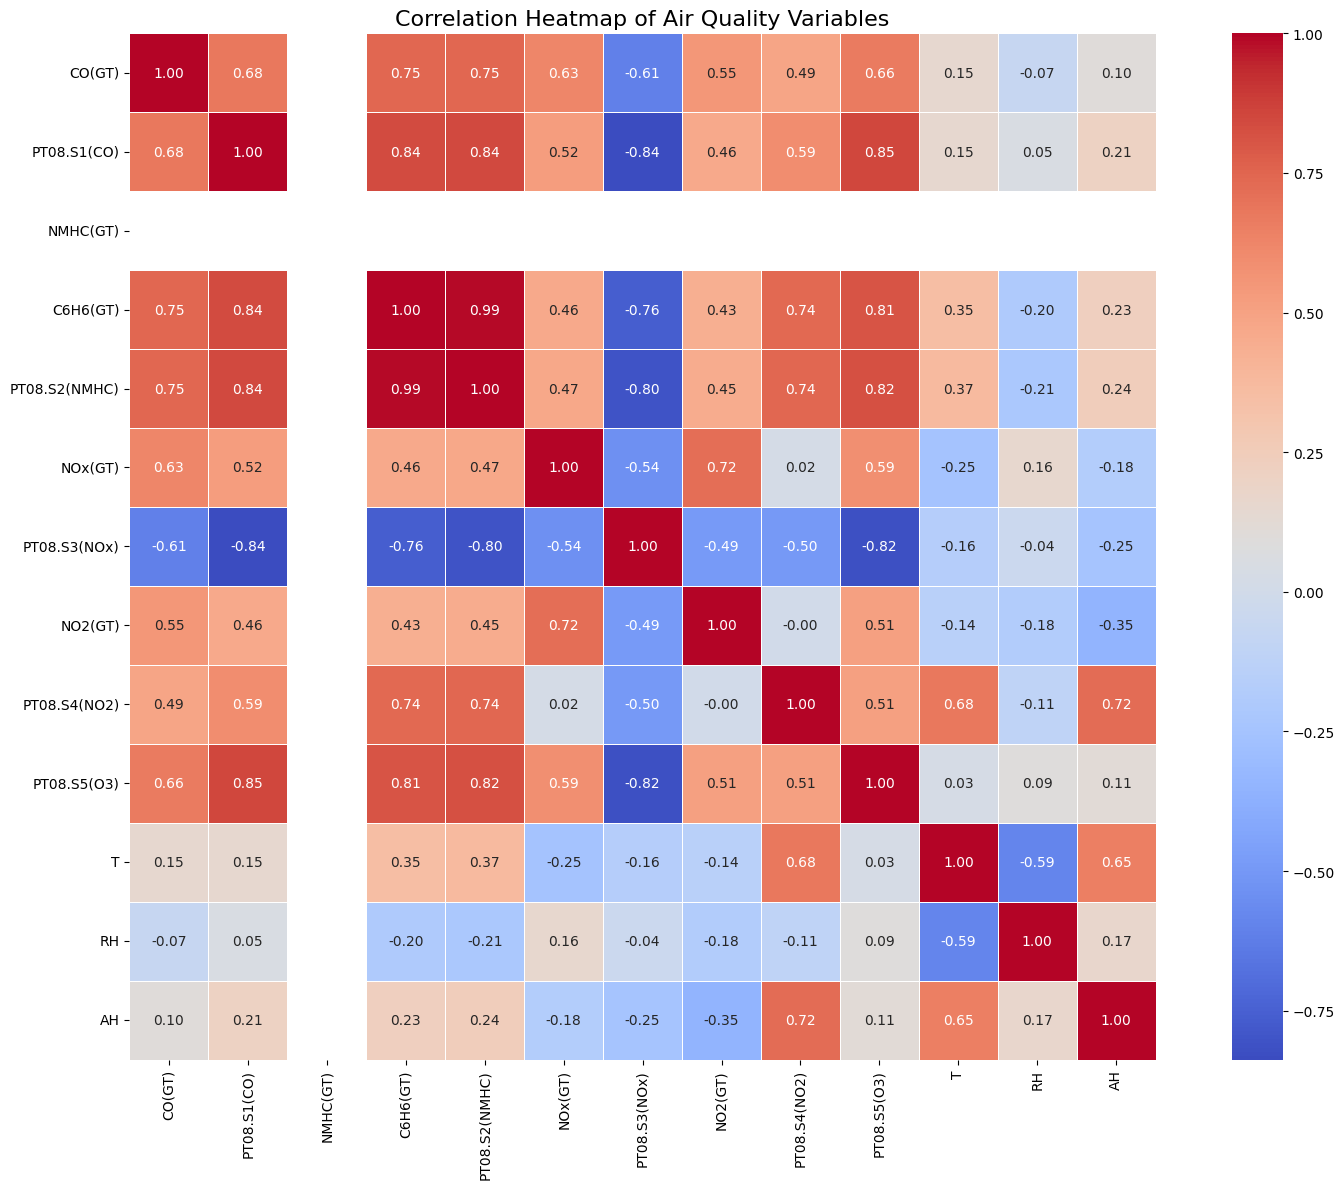

In [ ]:
# Correlation heatmap
plt.figure(figsize=(16, 12))
corr_matrix = df_air.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Air Quality Variables', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Selection

In [ ]:
X = df_air[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH']]
y = df_air['C6H6(GT)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Bayseian Regression

In [ ]:
# Bayesian Regression
model = BayesianRidge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Bayesian Regression ")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

Bayesian Regression 
MSE: 5.196418284696371
R²: 0.820765391247676
MAE: 1.7277540370981566


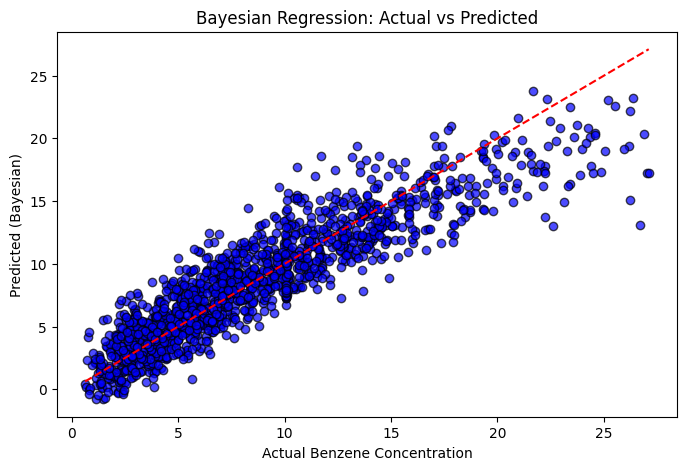

In [ ]:
# Visualization of Bayesian Regression
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Benzene Concentration')
plt.ylabel('Predicted (Bayesian)')
plt.title('Bayesian Regression: Actual vs Predicted')
plt.show()

## Testing

In [ ]:
model = BayesianRidge()
model.fit(X_train, y_train)

BayesianRidge()

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
print("Bayesian Regression")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Train R²: {r2_score(y_train, y_train_pred)}")
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred)}")

Bayesian Regression
Train MSE: 5.114035721330274
Train R²: 0.8207827579137221
Train MAE: 1.7121467524783929


## Comparing with Linear Regression and Random FOrest

## Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr)}")
print(f"R²: {r2_score(y_test, y_pred_lr)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")

Linear Regression
MSE: 5.1965857317976925
R²: 0.8207596156703364
MAE: 1.727863668978061


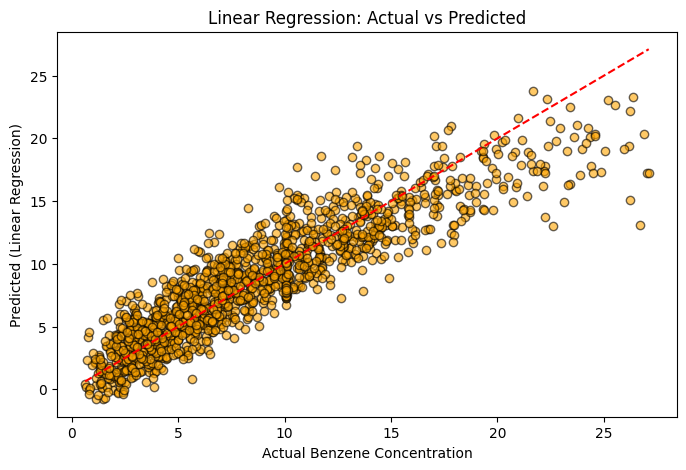

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_lr, color='orange', edgecolors=(0, 0, 0), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Benzene Concentration')
plt.ylabel('Predicted (Linear Regression)')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

## Random Forest Regression

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Regressor")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R²: {r2_score(y_test, y_pred_rf)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")

Random Forest Regressor
MSE: 2.778453738603871
R²: 0.9041657077064583
MAE: 1.1224951223632076


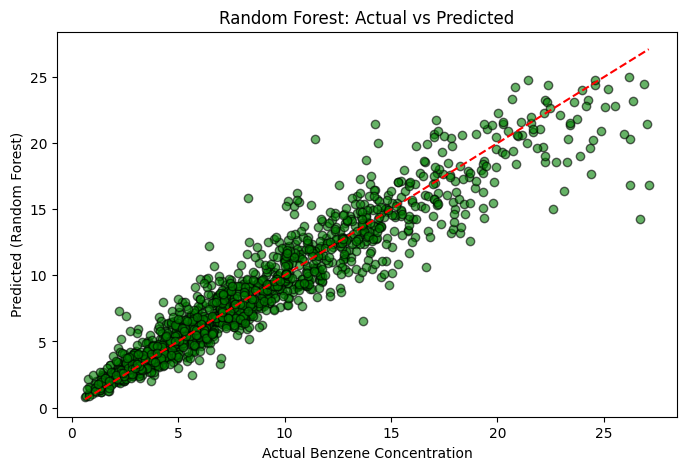

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, color='green', edgecolors=(0, 0, 0), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Benzene Concentration')
plt.ylabel('Predicted (Random Forest)')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

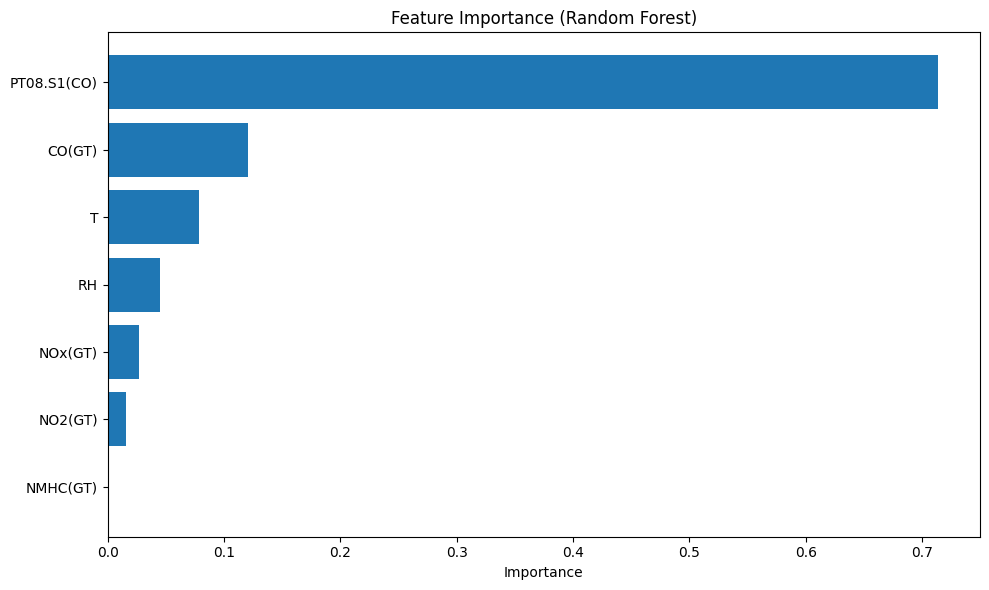

In [ ]:
importances = rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title("Feature Importance (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import BayesianRidge

In [ ]:
y_pred_bayes = model_bayes.predict(X_test)

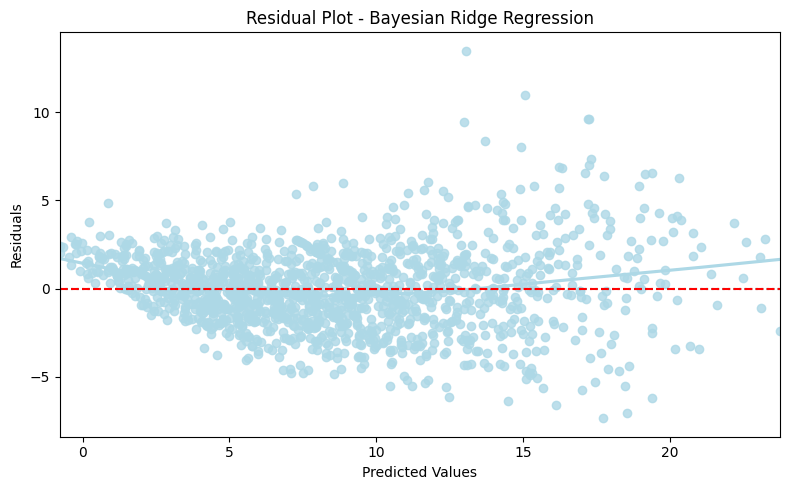

In [ ]:
residuals = y_test - y_pred_bayes
plt.figure(figsize=(8, 5))
sns.residplot(x=y_pred_bayes, y=residuals, lowess=True, color="lightblue")
plt.title("Residual Plot - Bayesian Ridge Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

## Results Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
results = {
    'Model': ['Bayesian Ridge', 'Linear Regression', 'Random Forest', 'GPR'],
    'R2 Score': [0.8207, 0.8207, 0.9041, 0.7912],
    'MSE': [5.20, 5.20, 2.77, 6.05],
    'MAE': [1.73, 1.73, 1.12, 1.69]
}

In [ ]:
df = pd.DataFrame(results)

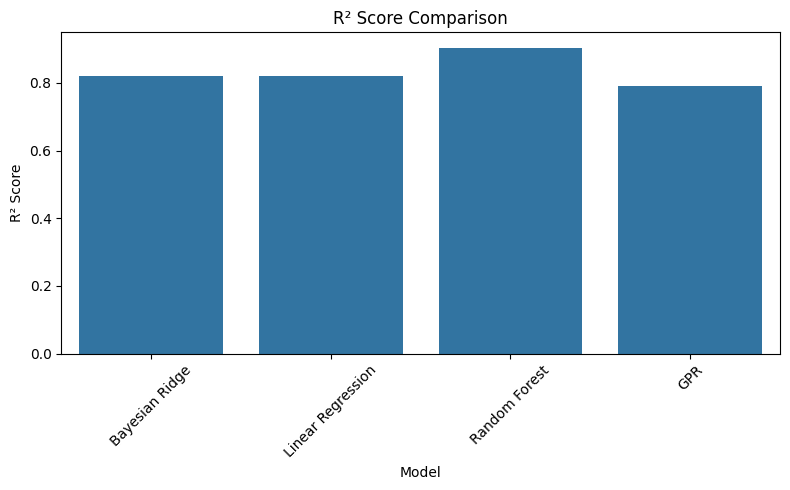

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2 Score', data=df)
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

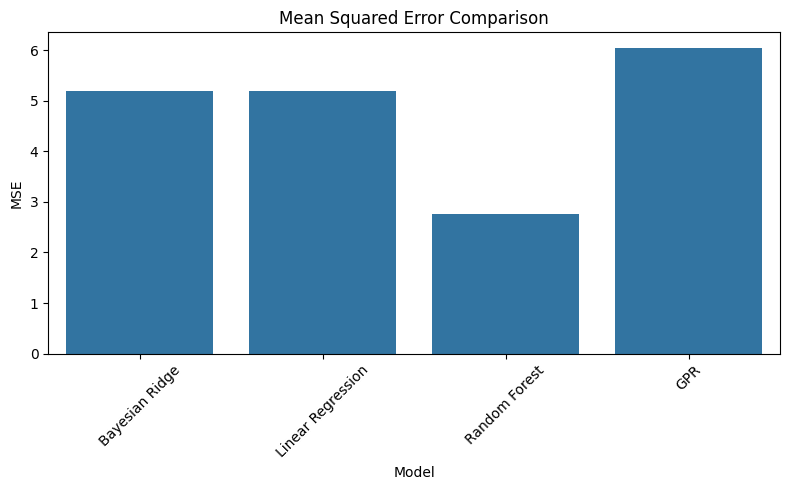

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MSE', data=df)
plt.title('Mean Squared Error Comparison')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

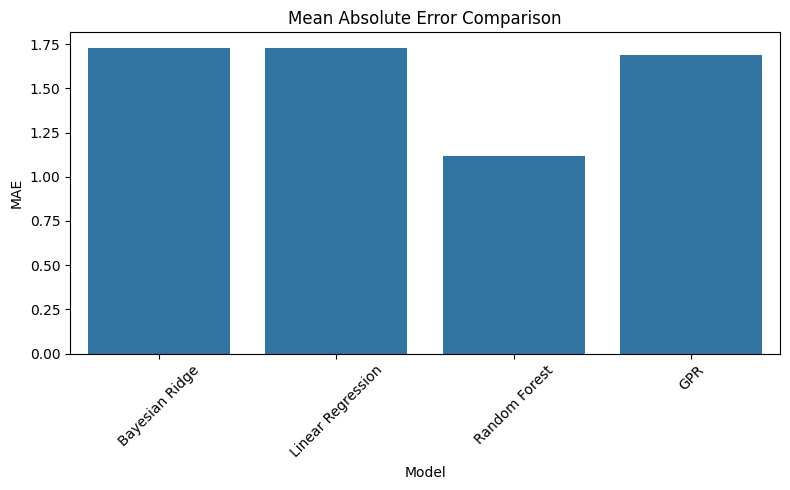

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=df)
plt.title('Mean Absolute Error Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Gaussain Process Regression

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
kernel = C(1.0) * RBF(length_scale=1.0)

In [ ]:
#only used 300 rows
X_sample = X_train.sample(n=300, random_state=42)
y_sample = y_train.loc[X_sample.index]

In [ ]:
# Training of GPR
gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1.0, n_restarts_optimizer=5)
gpr_model.fit(X_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1.0, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=5)

In [ ]:
# test data
y_pred_gpr, sigma = gpr_model.predict(X_test, return_std=True)

In [ ]:
print("Gaussian Process Regression")
print(f"MSE: {mean_squared_error(y_test, y_pred_gpr)}")
print(f"R²: {r2_score(y_test, y_pred_gpr)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gpr)}")

Gaussian Process Regression
MSE: 6.051335024165762
R²: 0.791277644319012
MAE: 1.6909019703211956


## Discrete Bayesian Network

In [ ]:
data_air = df_air[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'C6H6(GT)']].copy()
for col in data_air.columns:
    data_air[col] = pd.cut(data_air[col], bins=3, labels=['Low', 'Medium', 'High'])

## Train_Test_Split

In [ ]:
train_data_air, test_data_bn = train_test_split(data_air, test_size=0.2, random_state=42)

In [ ]:
hc = HillClimbSearch(train_data_air)

In [ ]:
best_model = hc.estimate(scoring_method=BIC(train_data_air))
model_bn = DiscreteBayesianNetwork(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
from pgmpy.estimators import BayesianEstimator
model_bn.fit(train_data_air, estimator=BayesianEstimator)

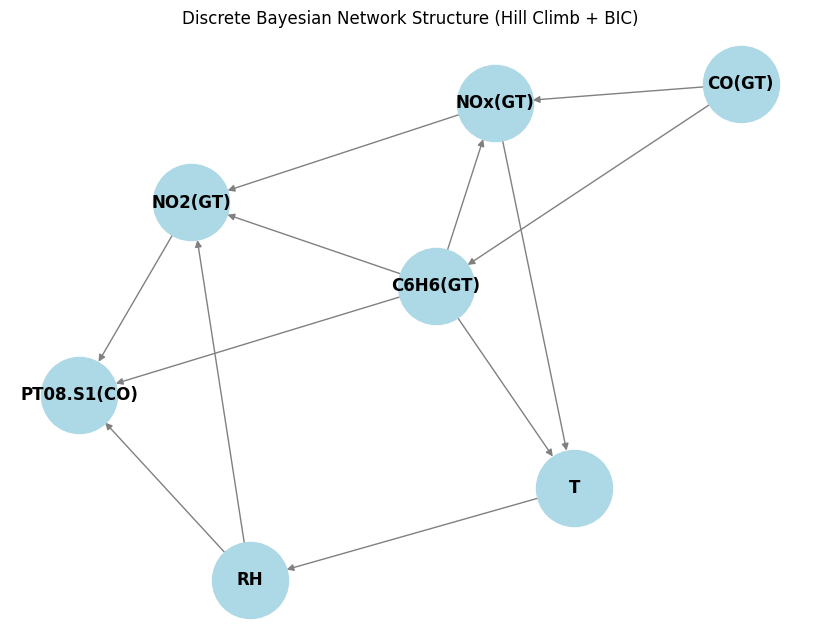

In [ ]:
#Plotting
plt.figure(figsize=(8, 6))
G = nx.DiGraph()
G.add_edges_from(model_bn.edges())
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=12, font_weight="bold", edge_color="gray")
plt.title("Discrete Bayesian Network Structure (Hill Climb + BIC)")
plt.show()

In [ ]:
#Inference
inference_train = VariableElimination(model_bn)
result_train = inference_train.query(variables=['C6H6(GT)'], evidence={'CO(GT)': 'High'})
print("Inference on Training Data:")
print(result_train)

Inference on Training Data:
+------------------+-----------------+
| C6H6(GT)         |   phi(C6H6(GT)) |
+==================+=================+
| C6H6(GT)(High)   |          0.5005 |
+------------------+-----------------+
| C6H6(GT)(Low)    |          0.0182 |
+------------------+-----------------+
| C6H6(GT)(Medium) |          0.4814 |
+------------------+-----------------+


In [ ]:
#Fitting
model_bn.fit(test_data_bn, estimator=BayesianEstimator)
inference_test = VariableElimination(model_bn)
result_test = inference_test.query(variables=['C6H6(GT)'], evidence={'CO(GT)': 'High'})
print("Inference on Test Data:")
print(result_test)

Inference on Test Data:
+------------------+-----------------+
| C6H6(GT)         |   phi(C6H6(GT)) |
+==================+=================+
| C6H6(GT)(High)   |          0.5020 |
+------------------+-----------------+
| C6H6(GT)(Low)    |          0.0235 |
+------------------+-----------------+
| C6H6(GT)(Medium) |          0.4744 |
+------------------+-----------------+


## Target Varible Visualisation

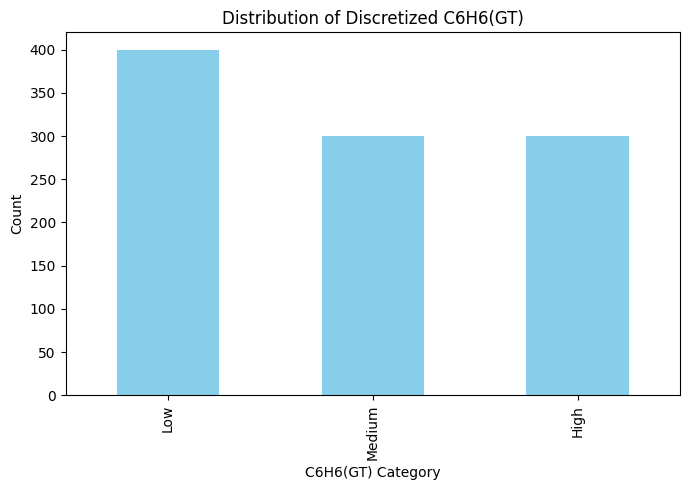

In [ ]:
sample_target = pd.Series([0.5, 1.2, 3.5, 5.7, 9.3, 12.1, 2.8, 4.4, 6.9, 11.0]*100)

target_binned = pd.qcut(sample_target, q=3, labels=['Low', 'Medium', 'High'])

# Plot the distribution
plt.figure(figsize=(7, 5))
target_binned.value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Discretized C6H6(GT)")
plt.xlabel("C6H6(GT) Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()